In [1]:
import jax.numpy as jnp
from jax import jit, vmap,lax
from jax import grad,jacfwd
import numpy as np
from functools import partial
from jax.config import config
from jax.scipy.sparse.linalg import gmres
config.update("jax_enable_x64", True)

In [2]:
class FEM():
    
    def __init__(self, N1, N2, 
                 left, right, bottom, top, 
                 source_term,
                 left_boundary, right_boundary, bottom_boundary, top_boundary):
        
        self.N1 = N1
        self.N2 = N2
        self.N = 2 * N1 * N2
        self.Nlb = 6
        self.left = left
        self.right = right
        self.bottom = bottom
        self.top = top
        self.source_term = source_term
        self.left_boundary = left_boundary
        self.right_boundary = right_boundary
        self.bottom_boundary = bottom_boundary
        self.top_boundary = top_boundary
        
        
    @partial(jit, static_argnums=0)
    def update_T(self,T, k):
        """
        Update a specific column of matrix T iteratively
        based on the value of the column k-2.

        Args:
            T (jax.numpy.ndarray): The matrix to be updated.
            k (int): The column (element) index.
            
        Returns:
            jax.numpy.ndarray: The updated matrix T.
        """
        return T.at[:, k].set(T[:, k-2] + 2)

    @partial(jit, static_argnums=0)
    def update_inner(self,T, i, j):
        N2 = self.N2
        return T.at[:, i*(2*N2)+1+j].set(T[:, i*(2*N2)-1+j] + 2)

    @partial(jit, static_argnums=0)
    def inner_loop(self,T, i):
        N2 = self.N2
        T = T.at[:, i*(2*N2)].set(T[:, i*(2*N2)-2] + 2*N2+4)
        T = T.at[:, i*(2*N2)+1].set(T[:, i*(2*N2)-1] + 2*N2+4)
        T = lax.fori_loop(1, 2*N2-1, lambda j, T: self.update_inner(T, i, j), T)
        return T

    @partial(jit,static_argnums=(0,))  
    def Tb_function_jax(self, n_e):
        """
        Define the connectivity for six-noded triangular elements in a mesh.
        
        Args:
            N1 (int): Number of intervals along the x-axis.
            N2 (int): Number of intervals along the y-axis.
            n_e (int): Index of the element.

        Returns:
            ndarray: A 1D array of size 6, representing the global indices of the 
                    nodes corresponding to the `n_e`-th element.

        Example:
            >>> Tb_function(16, 16, 16)
            Array([16, 82, 18, 49, 50, 17], dtype=int64)

        Notes:
            The connectivity is determined in a structured manner, ensuring that
            elements share nodes appropriately for the six-noded representation.

            'static_argnums=(0,1)' is used when jitting for DynamicJaxpr
            (See T = jnp.zeros((Nlb, N), dtype=int))
        """
        N1 = self.N1
        N2 = self.N2
        N = 2 * N1 * N2
        Nlb = 6
        
        T = jnp.zeros((Nlb, N), dtype=int)
        T = T.at[:, 0].set(jnp.array([0, 2*(2*N2+1), 2, 2*N2+1, 2*N2+2, 1]))
        T = T.at[:, 1].set(jnp.array([2, 2*(2*N2+1), 2*(2*N2+2), 2*N2+2, 2*(2*N2+1)+1, 2*N2+3]))
        
        T = lax.fori_loop(2, 2*N2, lambda k, T: self.update_T(T, k), T)
        T = lax.fori_loop(1, N1, lambda i, T: self.inner_loop(T, i), T)
        
        return T[:, n_e]
    
    @partial(jit, static_argnums=(0,))
    def Pb_function_jax(self, n_g):
        """
        Compute the global coordinates (x, y) for a given global node index.

        This function maps each global node index `n_g` to its corresponding
        x and y coordinates within a structured 2D grid.

        Args:
        - N1 (int): Number of intervals along the x-axis.
        - N2 (int): Number of intervals along the y-axis.
        - n_g (int): Global node index.

        Returns:
        - x (float): x-coordinate of the node corresponding to `n_g`.
        - y (float): y-coordinate of the node corresponding to `n_g`.

        The grid is formed by creating a mesh between `left` (-1) and `right` (1) in the x-direction,
        and between `bottom` (-1) and `top` (1) in the y-direction, with 2*N1+1 and 2*N2+1 points
        respectively. The function returns the x and y coordinates of the node corresponding to the global
        index `n_g`.
        
        Example:
        >>> Pb_function(16, 16, 16)
        (Array(-0.5625, dtype=float64), Array(0.5625, dtype=float64))
        """
        left = self.left
        right = self.right
        bottom = self.bottom
        top = self.top
        N1 = self.N1
        N2 = self.N2
        
        x_array = jnp.linspace(left, right, 2 * N1 + 1)
        y_array = jnp.linspace(bottom, top, 2 * N2 + 1)
        
        # Use JAX's vectorized operations to construct xlis and ylis
        # We use np.tile here for array iteration
        xlis = jnp.tile(x_array[:, None], (1, 2 * N2 + 1)).flatten()
        ylis = jnp.tile(y_array, (2 * N1 + 1))
        
        # Stack the xlis and ylis arrays to form P
        P = jnp.stack((xlis, ylis))
        
        x, y = P[:, n_g]
        return x, y
    
    @partial(jit, static_argnums=(0,))
    def pusi_jax(self,x, y, idx):
        """
        Compute the shape function for a 6-node triangular element based on the given node index, 
        which is used in FEM to define the behavior of elements within a mesh 

        Parameters:
        ----------
        x : float
            The x-coordinate within the triangular element.
        y : float
            The y-coordinate within the triangular element.
        idx : int
            The node index of one triangular element.

        Returns:
        -------
        float
            The value of the shape function at the provided (x, y) location for the specified node index.

        Raises:
        ------
        ValueError
            If `idx` is not in the range [0, 5].

        Examples:
        --------
        >>> pusi(0.5, 0.5, 0)
        0.25
        >>> pusi(0.5, 0.5, 4)
        0.5

        Notes:
        -----
        The shape functions are derived from the isoparametric mapping of a standard 
        6-node triangular element in the parametric space to the physical space.
        """
        
        value = jnp.where(idx == 0, 2 * x**2 + 2 * y**2 + 4 * x * y - 3 * y - 3 * x + 1,
                jnp.where(idx == 1, 2 * x**2 - x,
                jnp.where(idx == 2, 2 * y**2 - y,
                jnp.where(idx == 3, -4 * x**2 - 4 * x * y + 4 * x,
                jnp.where(idx == 4, 4 * x * y,
                jnp.where(idx == 5, -4 * y**2 - 4 * x * y + 4 * y,
                        jnp.nan)  # This last clause is for unmatched idx values
                )))))

        # Asserting instead of throwing an exception
        assert_message = "Invalid node index. 'idx' should be in the range [0, 5]."
        assert_condition = jnp.logical_or(jnp.logical_and(0 <= idx, idx <= 5), jnp.isnan(value))
        lax.cond(assert_condition, (), lambda _: _, (), lambda x: x)  # This will fail if the condition is False

        return value
    
    # Unified gradient function
    @partial(jit,static_argnums=(0,))
    def pusi_grad_jax(self,x, y, idx, direction=0):
        """
        Compute the gradient of the shape function for a 6-node triangular element using JAX's automatic differentiation.

        Parameters:
        ----------
        x : float
            The x-coordinate within the triangular element.
        y : float
            The y-coordinate within the triangular element.
        idx : int
            The node index. It specifies the node for which the shape function's derivative is being computed.
            Valid values are from 0 to 5 inclusive, corresponding to each of the 6 nodes of the triangular element.
        direction : int, optional
            Specifies the direction of the derivative.(x or y) 

        Returns:
        -------
        float
            The value of the derivative of the shape function at the provided (x, y) location for the specified node index
            and direction.

        Raises:
        ------
        ValueError
            If `idx` is not in the range [0, 5].

        Example:
        --------
        >>> pusi_grad_jax(0.0, 0.0, 0)
        Array(-3., dtype=float32, weak_type=True)   
        """
        dpu_dx = grad(self.pusi_jax, argnums=0)(x, y, idx)
        dpu_dy = grad(self.pusi_jax, argnums=1)(x, y, idx)
        
        # Use jnp.where for conditional return
        return jnp.where(direction == 0, dpu_dx, dpu_dy)
    
    def Fx_jax(self,x, y, J, dy31, dy12, idx):
        return self.pusi_grad_jax(x, y, idx, 0) * (dy31 / J) + self.pusi_grad_jax(x, y, idx, 1) * (dy12 / J)


    def Fy_jax(self, x, y, J, dx13, dx21, idx):
        return self.pusi_grad_jax(x, y, idx, 0) * (dx13 / J) + self.pusi_grad_jax(x, y, idx, 1) * (dx21 / J)
    
    @partial(jit, static_argnums=(0,))
    def gauss_quadrature_stiffness_jax(self, n_e, alpha, beta):
        
        """
        Calculate the stiffness matrix for a given element using Gaussian quadrature.
        It uses Gaussian quadrature with fixed 6 points to integrate over the element's domain.

        Args:
            n_e (int): The index of the finite element for which the stiffness matrix is calculated.
            alpha (int): The local node index for the row in the stiffness matrix.
            beta (int): The local node index for the column in the stiffness matrix.

        Returns:
            r (jax.numpy.ndarray): The computed stiffness matrix for the element
                
        """
        
        Fx_jax = self.Fx_jax 
        Fy_jax = self.Fy_jax
        index_lis = self.Tb_function_jax(n_e)
        
        @vmap
        def fetch_coordinates(index):
            return self.Pb_function_jax(index)
        
        X, Y = fetch_coordinates(index_lis)
        
        det_J = (X[1] - X[0]) * (Y[2] - Y[0]) - (X[2] - X[0]) * (Y[1] - Y[0])

        
        dy31 = Y[2] - Y[0]
        dy12 = Y[0] - Y[1]
        dx13 = X[0] - X[2]
        dx21 = X[1] - X[0]
        
        Ar = 0.5 * jnp.abs(X[0] * (Y[1] - Y[2]) + X[1] * (Y[2] - Y[0]) + X[2] * (Y[0] - Y[1]))
        
        r = (Ar / 3) * (
            Fx_jax(0.5, 0., det_J, dy31, dy12, alpha) * Fx_jax(0.5, 0., det_J, dy31, dy12, beta)
            + Fx_jax(0., 0.5, det_J, dy31, dy12, alpha) * Fx_jax(0., 0.5, det_J, dy31, dy12, beta)
            + Fx_jax(0.5, 0.5, det_J, dy31, dy12, alpha) * Fx_jax(0.5, 0.5, det_J, dy31, dy12, beta)
            + Fy_jax(0.5, 0., det_J, dx13, dx21, alpha) * Fy_jax(0.5, 0., det_J, dx13, dx21, beta)
            + Fy_jax(0., 0.5, det_J, dx13, dx21, alpha) * Fy_jax(0., 0.5, det_J, dx13, dx21, beta)
            + Fy_jax(0.5, 0.5, det_J, dx13, dx21, alpha) * Fy_jax(0.5, 0.5, det_J, dx13, dx21, beta)
        )
        
        return r
    
    
    @partial(jit, static_argnums=(0,))
    def boundaryedges_jax(self, k):
        
        """
        Return the global node index of boundary node!
        """
        N1 = self.N1
        N2 = self.N2
        
        Nb = (2 * N1 + 1) * (2 * N2 + 1)
        nbn = 4 * (N1 + N2)
        boundaryNode = jnp.zeros((2, nbn), dtype=int)
        boundaryNode = boundaryNode.at[0, :].set(-1)
        array = jnp.arange(Nb, dtype=int)
        mat = array.reshape((2 * N1 + 1, 2 * N2 + 1))
        top = mat[0, :]
        bottom = mat[2 * N1, :]
        left = mat[:, 0]
        right = mat[:, 2 * N2]
        right1 = jnp.flipud(right)
        top1 = jnp.flipud(top)
        
        bottom = bottom[1:]
        right1 = right1[1:]
        top1 = top1[1:-1]
        
        index = jnp.concatenate([left, bottom, right1, top1])
        boundaryNode = boundaryNode.at[1, :].set(index)
        return boundaryNode[1, k]
    
    @partial(jit, static_argnums=(0,))
    def get_stiffness_mat_jax(self):
        """
        Computes the stiffness matrix 'A' for a finite element using JAX.

        The stiffness matrix is constructed using Gaussian quadrature to integrate over each element,
        and assembled by looping over all elements and their local basis functions. 

        Boundary conditions are applied by setting the corresponding rows and columns of the boundary
        nodes to zero and placing a one on the diagonal, effectively removing those degrees of freedom
        from the system.

        Returns:
            A (jax.numpy.ndarray)
        """
        N1 = self.N1
        N2 = self.N2
        
        Nlb = 6
        Nb = (2 * N1 + 1) * (2 * N2 + 1)
        nbn = 4 * (N1 + N2)
        N = 2 * N1 * N2
        A = jnp.zeros((Nb, Nb))
        
        def body_fn(n, A):
            def inner_loop(alpha, val):
                def innermost_loop(beta, val):
                    r = self.gauss_quadrature_stiffness_jax(n, alpha, beta)
                    index_lis = self.Tb_function_jax(n)
                    return val.at[index_lis[beta], index_lis[alpha]].add(r)
                return lax.fori_loop(0, Nlb, innermost_loop, val)
            return lax.fori_loop(0, Nlb, inner_loop, A)
        
        A = lax.fori_loop(0, N, body_fn, A)
        
        def boundary_fn(k, A):
            i = self.boundaryedges_jax(k)
            A = A.at[i, :].set(0)
            A = A.at[i, i].set(1)
            return A
        
        A = lax.fori_loop(0, nbn, boundary_fn, A)
        return A
        
    
    @partial(jit,static_argnums=(0,))
    def F(self, x, y, X, Y):
        """
        Compute the source term value using a vectorized mapping 
        of basis functions.

        Args:
        - x (float): The x-coordinate of the point where the source term is evaluated.
        - y (float): The y-coordinate of the point where the source term is evaluated.
        - X (jax.numpy.ndarray): The array of x-coordinates of the nodes in the mesh.
        - Y (jax.numpy.ndarray): The array of y-coordinates of the nodes in the mesh.

        Returns:
        - f_value (float): The evaluated source term at the given point (x, y).
        """
        idx = jnp.arange(6)  # Create an array [0, 1, 2, 3, 4, 5]
    
        # Adjust the in_axes and out_axes arguments to handle scalar x and y inputs
        vectorized_pusi_jax = vmap(self.pusi_jax, in_axes=(None, None, 0), out_axes=0)
    
        # Compute x0 and y0 in a vectorized manner
        pusi_values_x = vectorized_pusi_jax(x, y, idx)
        pusi_values_y = vectorized_pusi_jax(x, y, idx)
        x0 = jnp.dot(X, pusi_values_x)
        y0 = jnp.dot(Y, pusi_values_y)
    
        # Evaluate the custom source term function
        f_value = self.source_term(x0, y0)
    
        return f_value
    
    @partial(jit, static_argnums=(0,))
    def gauss_quadrature_load_jax(self, n, idx):
        """
        Perform Gaussian quadrature to compute the load vector for a given element and basis function index.
        
        Args:
            n (int): The element index for which the load vector is to be computed.
            idx (int): The basis function index within the element.

        Returns:
            float: The result of the Gaussian quadrature, representing an entry of the load vector for the 
            specified element and basis function index.

        """
        Nlb = 6
        # Use jnp.array
        X = jnp.zeros(Nlb)
        Y = jnp.zeros(Nlb)
        index_lis = self.Tb_function_jax( n)
        @vmap
        def fetch_coordinates(index):
            return self.Pb_function_jax(index)
        
        X, Y = fetch_coordinates(index_lis)

        Ar = 0.5 * abs(X[0] * (Y[1] - Y[2]) + X[1] * (Y[2] - Y[0]) + X[2] * (Y[0] - Y[1]))
        r = (Ar / 3) * (
            self.F(0.5, 0, X, Y) * self.pusi_jax(0.5, 0, idx)
            + self.F(0, 0.5, X, Y) * self.pusi_jax(0, 0.5, idx)
            + self.F(0.5, 0.5, X, Y) * self.pusi_jax(0.5, 0.5, idx)
        )
        return r
    
    @partial(jit,static_argnums=(0,))
    def Direclet_BC_fun(self, x, y, boundary_id):
        def true_fun(_):
            return jnp.array([self.left_boundary(x, y), self.right_boundary(x, y), self.bottom_boundary(x, y), self.top_boundary(x, y)])[boundary_id]

        def false_fun(_):
            return 0.0  # Default value for invalid boundary_id

        # Check if boundary_id is within a valid range
        is_valid = (boundary_id >= 0) & (boundary_id < 4)

        return lax.cond(is_valid, true_fun, false_fun, operand=None)
    
    
    @partial(jit, static_argnums=(0,))
    def get_load_vector_jax(self):
        N1 = self.N1
        N2 = self.N2
        
        Nlb = 6
        nbn = 4 * (N1 + N2)
        N = 2 * N1 * N2  # Number of finite element is 2*N1*N2 (Triangle element)
        Nb = (2 * N1 + 1) * (2 * N2 + 1)
        b = jnp.zeros((Nb, 1))

        def body_fn(n, b):
            def inner_loop(beta, val):
                r = self.gauss_quadrature_load_jax(n, beta)
                index_lis = self.Tb_function_jax(n)
                return val.at[index_lis[beta], 0].add(r)
            return lax.fori_loop(0, Nlb, inner_loop, b)
        
        b = lax.fori_loop(0, N, body_fn, b)

        def boundary_fn(k, b):
            i = self.boundaryedges_jax(k)
            x, y = self.Pb_function_jax(i)
            
            # Assuming that the boundary nodes are at the extreme coordinates
            # You might need to adjust the logic based on how your nodes are laid out
            boundary_id = jnp.where(x == -1, 0,   # left boundary
                        jnp.where(x == 1, 1,    # right boundary
                        jnp.where(y == -1, 2,   # bottom boundary
                        jnp.where(y == 1, 3,    # top boundary
                        -1))))  # -1 for internal nodes which should not be on the boundary
            
            boundary_value = self.Direclet_BC_fun(x, y,boundary_id)
            return b.at[i, 0].set(boundary_value)
        
        b = lax.fori_loop(0, nbn, boundary_fn, b)
        return b
    
    @partial(jit, static_argnums=(0,))
    def residual(self, u):
        A = self.get_stiffness_mat_jax()  # Compute stiffness matrix
        b = self.get_load_vector_jax()    # Compute load vector
        return A @ u - b                  # Compute residual
    
    @partial(jit, static_argnums=(0,))
    def newton_step(self, u):
        A = self.get_stiffness_mat_jax()         # Stiffness matrix (Jacobian)
        residual = self.residual(u)              # Current residual
        
        # Solve for the update direction Δu
        Δu, _ = gmres(lambda x: A @ x, -residual)
        
        u += Δu   # Update the solution
        return u
    
    @partial(jit, static_argnums=(0,))
    def solve(self, tolerance=1.0e-4):
        u = jnp.zeros(((2 * self.N1 + 1) * (2 * self.N2 + 1), 1))  # Initial guess for u
        
        # While-loop in JAX for the Newton-Raphson method
        def cond_fun(u):
            return jnp.linalg.norm(self.residual(u)) > tolerance

        u = lax.while_loop(cond_fun, self.newton_step, u)
        return u



In [3]:
@jit
# Define a custom source term function
def custom_source_term(x, y):
    return -y * (1 - y) * (1 - x - 0.5 * x**2) * jnp.exp(x + y) - x * (1 - 0.5 * x) * (-3 * y - y**2) * jnp.exp(x + y)

# Define individual boundary functions
@jit
def left_boundary(x, y):
    return -1.5 * y * (1 - y) * jnp.exp(-1 + y)
@jit
def right_boundary(x, y):
    return 0.5 * y * (1 - y) * jnp.exp(1 + y)
@jit
def bottom_boundary(x, y):
    return -2 * x * (1 - 0.5 * x) * jnp.exp(x - 1)
@jit
def top_boundary(x, y):
    return 0.0

N1, N2 = 16, 16
myFEM = FEM(N1, N2,
            -1, 1, -1, 1,
            custom_source_term, left_boundary, right_boundary, bottom_boundary, top_boundary)

In [4]:
A = myFEM.get_stiffness_mat_jax()
b = myFEM.get_load_vector_jax()

In [5]:
u = jnp.dot(jnp.linalg.inv(A),b)
print("u is: ",'\n',u)

u is:  
 [[0.40600585]
 [0.3925172 ]
 [0.37739699]
 ...
 [0.3566073 ]
 [0.20336062]
 [0.        ]]


In [6]:
u_Newton = myFEM.solve()

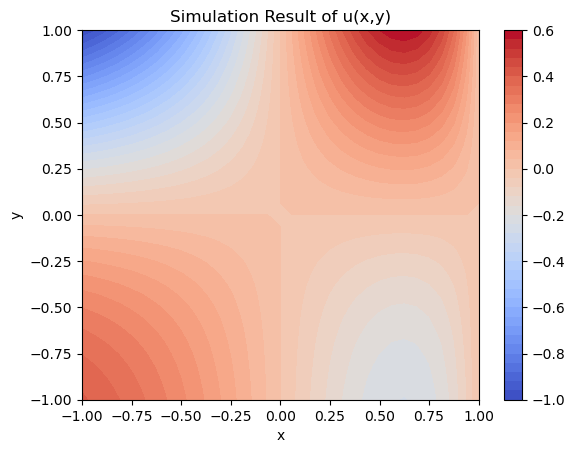

In [7]:
import matplotlib.pyplot as plt

# Reshape u to the grid size
U = u.reshape((2*N1+1, 2*N2+1))

# Create meshgrid
x = jnp.linspace(-1, 1, 2*N1+1)
y = jnp.linspace(-1, 1, 2*N2+1)
X, Y = jnp.meshgrid(x, y)

# Plot
fig, ax = plt.subplots()
c = ax.contourf(X, Y, U, 50, cmap='coolwarm')
fig.colorbar(c, ax=ax)
ax.set_title('Simulation Result of u(x,y)')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

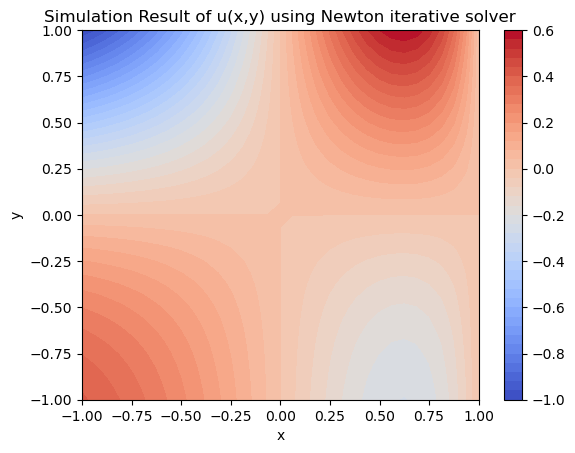

In [9]:
import matplotlib.pyplot as plt

# Reshape u to the grid size
U = u_Newton.reshape((2*N1+1, 2*N2+1))

# Create meshgrid
x = jnp.linspace(-1, 1, 2*N1+1)
y = jnp.linspace(-1, 1, 2*N2+1)
X, Y = jnp.meshgrid(x, y)

# Plot
fig, ax = plt.subplots()
c = ax.contourf(X, Y, U, 50, cmap='coolwarm')
fig.colorbar(c, ax=ax)
ax.set_title('Simulation Result of u(x,y) using Newton iterative solver')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

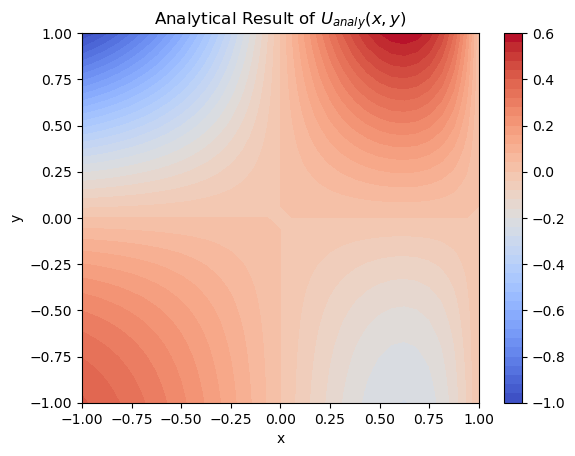

In [8]:
# Analytical function
def U_analy(x,y):
    return x*y*(1-0.5*y)*(1-x)*np.exp(x+y)

# Define mesh
x = np.linspace(-1, 1, 2*N1+1)
y = np.linspace(-1, 1, 2*N2+1)
X, Y = np.meshgrid(x, y)

# Compute analytical values on the mesh
Z = U_analy(X,Y)

# Plot
fig, ax = plt.subplots()
c = ax.contourf(X, Y, Z, 50, cmap='coolwarm')
fig.colorbar(c, ax=ax)
ax.set_title('Analytical Result of $U_{analy}(x,y)$')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()